<a href="https://colab.research.google.com/github/gamesMum/Arabic_Handwriting_Recognition/blob/master/Arabic_letter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset
https://www.kaggle.com/rashwan/arabic-chars-mnist/discussion?sortBy=hot&group=all&page=1&pageSize=20&category=all

In [21]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
#navigate to the directory
import os
os.chdir('/content/drive/My Drive/Arabic dataset')

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np

import matplotlib.pyplot as plt

#import nonechucks as nc
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


In [24]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [35]:
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision as tv
batch_size=64
valid_size=0.2

#define the transforms
transform  = transforms.Compose([
                                 transforms.ToTensor(), 
                                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

'''transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5, 0.5), (0.5,0.5,0.5))])#for one channel only'''
#create the dataset
train_data = datasets.ImageFolder('train', transform=transform)
test_data = datasets.ImageFolder('test', transform=transform)

#obtain trainig indicies that will be used in validation  
num_train = len(train_data)
indicies = list(range(num_train))
np.random.shuffle(indicies)

split = int(np.floor(valid_size * num_train)) #how many indicies we should take

train_idx, valid_idx = indicies[split:], indicies[:split]

#Define sampler for each data collection (train and valid)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
print('batch_size: ', batch_size)
print('length of train dataset: ', len(train_data))
print('length of test dataset: ',len(test_data))
#print('length of valid dataset: ',len(valid_data))
# specify the Alphabit classes
classes = ['ain', 'alef', 'beh', 'dad', 'dal', 'feh', 'ghain', 'hah', 'heh', 'jeem', 'kaf',
           'khah', 'lam', 'meem', 'noon', 'qaf', 'reh', 'sad', 'seen', 'sheen', 'tah', 'teh',
           'thal', 'theh', 'waw', 'yeh', 'zah', 'zain']

#get one batch of training images
dataiter = iter(train_loader) #now contains the first batch
images, labels = dataiter.next() 
print(images.shape)#images transformed to greyscale

batch_size:  64
length of train dataset:  13440
length of test dataset:  3360
torch.Size([64, 3, 32, 32])


## **Visualizing the data**

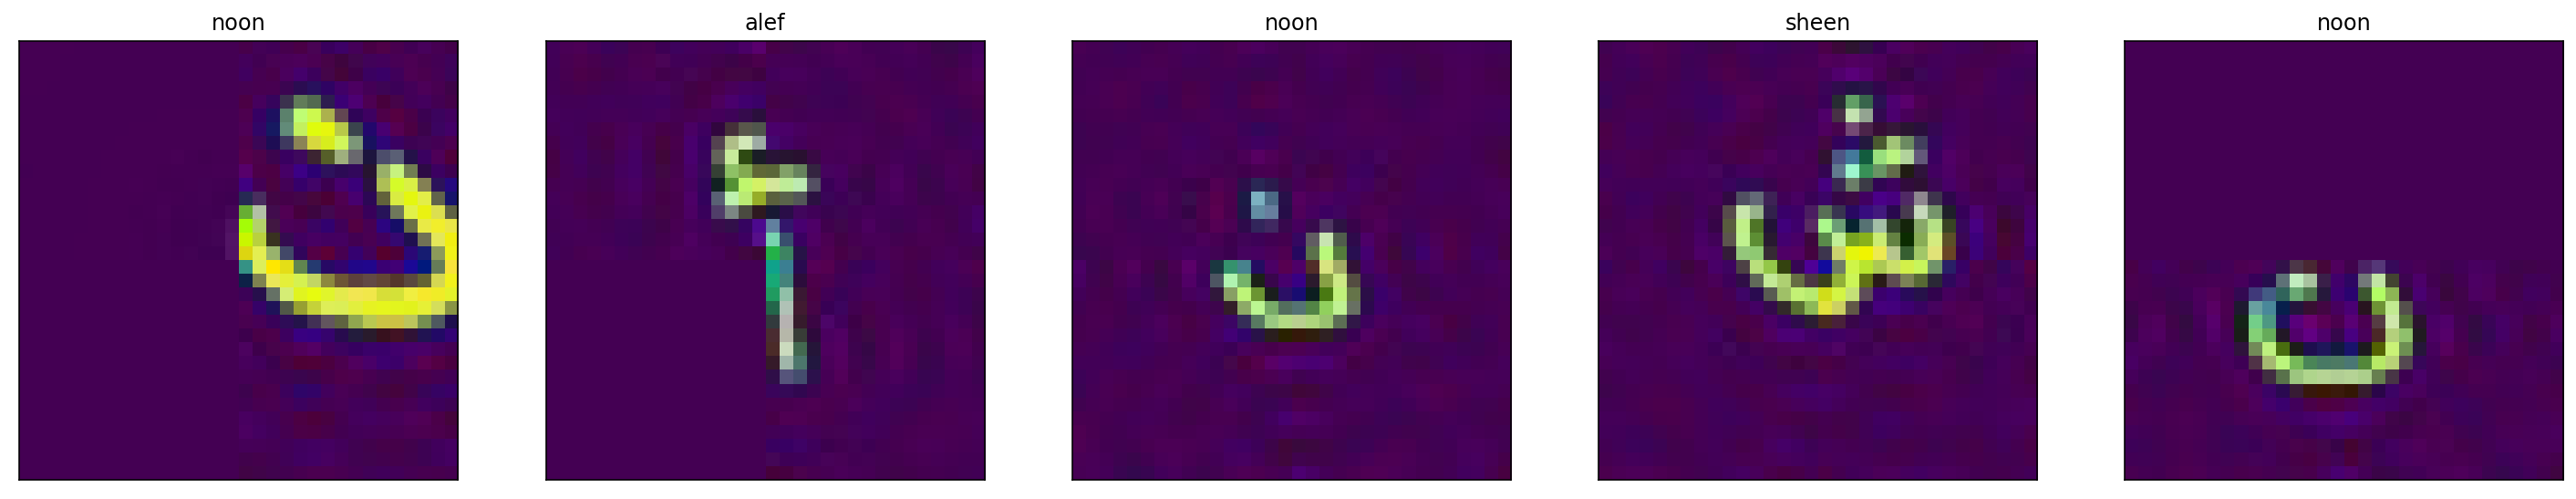

In [36]:
def imshow(img):
  img = img /2+0.5 #unormalize the images
  plt.imshow(np.transpose(img, (1, 2, 0))) #convert it back from tensor to image

#get one batch of training images
dataiter = iter(train_loader) #now contains the first batch
images, labels = dataiter.next() #images=the first batch of images, labels= the first batch of labels
images = images.numpy() #convert the images to display them

#plot the imahes in the batch along with the corresponding labels
fig = plt.figure(figsize=(25,6))
#display 5 images
for idx in np.arange(5):
  ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[]) #(rows, cols, index, .., ..)
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])



In [37]:
#Load pre traind model
model = models.densenet161(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
for param in model.parameters():
  param.requires_grad=False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2208, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(500, 28)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier
if train_on_gpu:
  model.cuda()

In [39]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
if train_on_gpu:
  model.cuda()

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
n_epochs = 1
valid_loss_min = np.Inf
for epoch in range(1, n_epochs + 1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)
    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item() * data.size(0)
    # calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'arabic_model.pt')
        valid_loss_min = valid_loss

In [0]:
#load saved model
model.load_state_dict(torch.load('arabic_model'))

In [0]:
#Test the model
test_loss = 0.0

class_correct = list(0. for i in range(6))
class_total = list (0. for i in range(6))

#set the model to test and validation mode (no gradient descent needed)
model.eval()

for data, target in test_loader:
  #move the tensor to GPU ig available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  #forward pass: compute prediction output by passing the first batch of test data
  output = model(data)
  #calculate the batch size
  loss = criterion(output, target)
  #update the test loss
  test_loss += loss.item()*data.size(0)
  #convert output probabilities to output class
  _, pred = torch.max(output, 1)
  #compare the prediction to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  #conveert to numpy array and remove the extra dimention and get only the result
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  #calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i] #get the corresponding label from the object
    class_correct[label] += correct[i].item()
    class_total[label] += 1
  
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
  if class_total[i] > 0:
     print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
       print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
   


In [0]:
#Visualizing a sample tested of data
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

#Move model inputs to cuda
if train_on_gpu:
  images = images.cuda()

#get sample outputs
output = model(images)
#convert probabilties to prediction class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))